# Solving the [8-puzzle](https://8-puzzle.readthedocs.io/en/latest/) (with a slight twist)
## Heuristic search vs uninformed search, admissibility, performance tests, empirical results, and some charts! Fun stuff ahead


Instead of only being able to slide tiles vertically and horizontally (with a cost of 1), when the empty tile is at a corner, the tiles on the same row (or on the same column) can wrap around (if you have more than two rows) with a cost of 2. Similarly the diagonal tiles (both the adjacent one and the opposing corner) can slide into an empty corner with a cost of 3. We use the number 0 to represent the empty tile.

In [50]:
# you need to install these in your env to run this notebook
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# local modules, no installs needed
from board import Board
from node import Node
import search
from heuristics import hamming_distance, manhattan_distance, row_col_out_of_place, euclidean_distance, permutation_inversion



We have implemented a bunch of heuristics, but we don't know which are the best for our problem. We know from theory that hamming distance and manhattan distance are both [admissible](https://en.wikipedia.org/wiki/Admissible_heuristic) and that permutation inversion is not. But we came up with two new heuristics and would like to know about their admissibility.


1. Rows and columns out of place: 

    Is the sum of all tiles that are out of their goal row position and all tiles that are out of their goal column position. For example, if a tile is out of both row and column position it adds 2 to the running sum of the heuristic, if it's out of either row or column it adds 1 to the sum and if the tile is in its goal position it add 0 to the heuristic sum. We expect it to be admissible because when conceptually compared with hamming and manhattan distance, this heuristic seems to be more optimistic than manhattan distance but slightly less optimistic than hamming distance. 

2. Euclidean distance:

    is the sum of the euclidean distances between each tile and it's goal position. Euclidean distance should be more optimistic than manhattan distance for the following reason: given any two coordinates on the board manhattan distance calculates the number of steps that the tile has to move but the tile is restricted to moves that are parallel to the x-axis or the y-axis. if you were to take any two tiles and draw the euclidean and manhattan distance between them you would get a right triangle where the euclidean distance draws the hypothenuse and the manhattan distance draws the opposite and adjacent sides. The hypothenuse is always smaller than the sum of the two other sides, which is why we expect euclidean distance to be admissible.



In order to validate our intuition, we will generate 100 random [8-puzzles](https://8-puzzle.readthedocs.io/en/latest/) in 2x4 and 3x3 format and run algorithms A* and Greedy Best First Search using these heuristics. Of course to verify whether we get the shortest cost solution path to those puzzle we will also run Uniform Cost Search to obtain the shortest paths with certainty.

In [2]:
HEURISTICS = [hamming_distance, manhattan_distance, row_col_out_of_place, euclidean_distance, permutation_inversion]

NUMBER_PUZZLES = 50

two_by_two = [np.random.permutation(8).reshape(2,4) for _ in range(NUMBER_PUZZLES)]

three_by_three = [np.random.permutation(9).reshape(3,3) for _ in range(NUMBER_PUZZLES)]



In [3]:
print(f"Here are the {NUMBER_PUZZLES} random 2x4 puzzles")
for puzzle in two_by_two:
    print(puzzle)

Here are the 50 random 2x4 puzzles
[[7 5 1 2]
 [0 3 4 6]]
[[0 3 1 4]
 [5 6 2 7]]
[[5 7 6 3]
 [4 1 2 0]]
[[7 1 6 4]
 [5 2 0 3]]
[[1 0 7 3]
 [4 5 2 6]]
[[1 3 6 7]
 [0 4 2 5]]
[[1 4 5 3]
 [0 7 2 6]]
[[1 7 3 2]
 [5 0 6 4]]
[[4 2 0 5]
 [1 6 3 7]]
[[1 7 0 6]
 [3 5 2 4]]
[[3 2 7 0]
 [1 5 6 4]]
[[6 2 5 3]
 [4 7 0 1]]
[[0 5 6 1]
 [3 7 4 2]]
[[0 2 3 4]
 [5 6 1 7]]
[[3 4 1 0]
 [5 7 2 6]]
[[5 4 6 3]
 [0 2 1 7]]
[[3 2 7 1]
 [6 4 5 0]]
[[4 1 5 0]
 [7 3 2 6]]
[[5 2 1 0]
 [7 6 4 3]]
[[0 1 5 6]
 [4 7 2 3]]
[[4 1 3 5]
 [0 6 2 7]]
[[4 7 1 0]
 [5 2 3 6]]
[[5 2 6 3]
 [4 1 0 7]]
[[6 3 0 7]
 [4 5 2 1]]
[[1 4 3 0]
 [5 7 2 6]]
[[3 1 6 5]
 [4 7 2 0]]
[[0 3 6 1]
 [2 5 4 7]]
[[3 6 5 1]
 [0 2 4 7]]
[[1 2 3 5]
 [6 4 7 0]]
[[7 0 1 4]
 [5 2 3 6]]
[[5 0 6 3]
 [2 7 4 1]]
[[1 5 0 3]
 [7 6 2 4]]
[[4 1 3 7]
 [0 6 2 5]]
[[2 5 1 6]
 [7 0 4 3]]
[[3 0 1 2]
 [6 7 5 4]]
[[7 3 2 1]
 [5 4 0 6]]
[[5 4 6 1]
 [3 0 2 7]]
[[0 3 6 2]
 [1 5 4 7]]
[[4 7 5 2]
 [6 1 3 0]]
[[6 3 5 2]
 [4 0 7 1]]
[[0 6 1 7]
 [4 2 3 5]]
[[0 6 4 5]
 [2 3 1 7]]

In [4]:
print(f"Here are the {NUMBER_PUZZLES} random 3x3 puzzles")
for puzzle in three_by_three:
    print(puzzle)

Here are the 50 random 3x3 puzzles
[[8 6 0]
 [3 4 2]
 [1 7 5]]
[[0 4 5]
 [8 6 2]
 [3 7 1]]
[[7 5 2]
 [3 1 6]
 [4 0 8]]
[[0 8 6]
 [5 7 2]
 [3 4 1]]
[[4 2 3]
 [5 0 6]
 [7 1 8]]
[[8 6 4]
 [5 7 1]
 [0 2 3]]
[[2 4 6]
 [8 0 5]
 [3 1 7]]
[[3 2 4]
 [5 1 8]
 [6 7 0]]
[[2 1 6]
 [5 4 0]
 [7 3 8]]
[[4 3 6]
 [2 1 5]
 [0 8 7]]
[[2 8 4]
 [3 6 7]
 [1 5 0]]
[[0 7 1]
 [5 8 3]
 [4 6 2]]
[[4 1 7]
 [6 0 5]
 [3 8 2]]
[[0 3 7]
 [4 2 5]
 [8 6 1]]
[[5 2 4]
 [3 7 6]
 [8 1 0]]
[[6 5 2]
 [0 1 3]
 [4 7 8]]
[[6 4 1]
 [7 5 2]
 [0 3 8]]
[[5 3 4]
 [7 2 1]
 [0 8 6]]
[[3 8 7]
 [2 0 5]
 [6 4 1]]
[[0 6 8]
 [7 1 4]
 [3 2 5]]
[[4 2 1]
 [0 7 5]
 [6 3 8]]
[[2 8 6]
 [5 4 0]
 [3 1 7]]
[[8 1 3]
 [0 4 5]
 [7 6 2]]
[[7 5 0]
 [8 3 4]
 [6 2 1]]
[[7 5 0]
 [4 6 2]
 [3 8 1]]
[[2 7 3]
 [0 5 8]
 [6 1 4]]
[[0 7 1]
 [2 5 3]
 [8 6 4]]
[[1 2 3]
 [8 0 5]
 [7 4 6]]
[[2 6 3]
 [0 5 7]
 [8 4 1]]
[[7 3 2]
 [6 4 1]
 [0 8 5]]
[[3 5 8]
 [2 6 0]
 [7 1 4]]
[[8 3 5]
 [0 4 6]
 [1 7 2]]
[[5 4 7]
 [1 0 6]
 [3 8 2]]
[[8 4 2]
 [3 0 5]
 [6 7 1]]
[[8 7 2]
 [6 

In [5]:
def build_experiment_object():
    '''Build's the structure that will run the experiment and hold results'''
    experiment = {}
    for func in HEURISTICS:
        experiment[func.__name__] = {
            'func': func,
            'algos': {
                'GBF': {
                    'func': search.greedy_best_first,
                    'shape': {
                        (2, 4): {'results': []},
                        (3, 3): {'results': []}
                    }
                },
                'A*': {
                    'func': search.a_star,
                    'shape': {
                        (2, 4): {'results': []},
                        (3, 3): {'results': []}
                    }
                }
            },
        }

    return experiment

experiment = build_experiment_object()

In [6]:
def run_experiment(experiment: dict, puzzles: list):
    for heurist_name in tqdm(experiment):
        heuristic_func = experiment[heurist_name]['func']

        for algo_name in experiment[heurist_name]['algos']:
            algo_func = experiment[heurist_name]['algos'][algo_name]['func']

            for puzzle in puzzles:
                b = Board(puzzle)
                result: dict = algo_func(board=b, H=heuristic_func)
                experiment[heurist_name]['algos'][algo_name]['shape'][puzzle.shape]['results'].append(result)

    return experiment

#### Let's Run A* and Greedy Best First search on the 50 2x4 puzzles

In [7]:

print('\nRunning 2 search algorithms on 50 puzzles, 5 different times to test the 5 heuristics:')
start = time.time()

run_experiment(experiment,two_by_two)

elapsed = round(time.time()-start, 2)
print(f'\n\nTotal of 2x50x5 = {2*50*5} puzzles solved in {elapsed} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]
Running 2 search algorithms on 50 puzzles, 5 different times to test the 5 heuristics:
100%|██████████| 5/5 [01:48<00:00, 21.76s/it]

Total of 2x50x5 = 500 puzzles solved in 108.84 seconds



#### Now Let's Run the same algorithms with the same heuristics on the 3x3 puzzles

In [40]:
start = time.time()

run_experiment(experiment, three_by_three)

elapsed = round(time.time()-start, 2)
print(f'\n\nTotal of 2x50x5 = {2*50*5} puzzles solved in {elapsed} seconds')

100%|██████████| 5/5 [18:13<00:00, 218.76s/it]

Total of 2x50x5 = 500 puzzles solved in 1093.82 seconds



In [41]:
def generate_stats(experiment):
    prototype = {
        'GBF': {
            'hamming_distance': {},
            'manhattan_distance': {},
            'row_col_out_of_place': {},
            'euclidean_distance': {},
            'permutation_inversion': {}
        },
        'A*': {
            'hamming_distance': {},
            'manhattan_distance': {},
            'row_col_out_of_place': {},
            'euclidean_distance': {},
            'permutation_inversion': {}
        }
    }
    global_stats = {
        (2,4): dict.copy(prototype),
        (3,3): dict.copy(prototype),
        }
    stats = {}
    timeouts = 0
    result_count = 0

    for heuristic in experiment:

        for algo in experiment[heuristic]['algos']:
            
            for shape in experiment[heuristic]['algos'][algo]['shape']:

                results = experiment[heuristic]['algos'][algo]['shape'][shape]['results']
                
                runtimes = [r['runtime'] for r in results]
                costs = np.array([r['current_node'].total_cost for r in results])
                num_visited_nodes = np.array([r['visited_nodes'] for r in results])
                print(f'runtimes:\n{runtimes}\n mean is {np.mean(runtimes)}')
                print(f'shape is {shape}')

                mean_runtime = np.mean(runtimes)
                mean_cost = np.mean(costs)
                mean_vis_nodes = np.mean(num_visited_nodes)
                
                global_stats[shape][algo][heuristic]['mean_runtime'] = mean_runtime
                global_stats[shape][algo][heuristic]['mean_cost'] = mean_cost
                global_stats[shape][algo][heuristic]['mean_visited_nodes'] = mean_vis_nodes
                global_stats[shape][algo][heuristic]['std_runtime'] = np.std(runtimes)
                global_stats[shape][algo][heuristic]['std_cost'] = np.std(costs)
                global_stats[shape][algo][heuristic]['std_visited_nodes'] = np.std(num_visited_nodes)
                
                timeouts += len([1 for r in results if not r['success']])
    
    print(f'number of timeouts = {timeouts}.')

    return global_stats


In [42]:
stats = generate_stats(experiment)
stats

runtimes:
[0.02, 0.04, 0.01, 0.02, 0.02, 0.01, 0.02, 0.06, 0.0, 0.01, 0.01, 0.06, 0.05, 0.01, 0.01, 0.0, 0.01, 0.02, 0.01, 0.06, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.04, 0.03, 0.01, 0.01, 0.02, 0.02, 0.02, 0.05, 0.02, 0.02, 0.01, 0.07, 0.11, 0.01, 0.01, 0.01, 0.03, 0.02, 0.03, 0.02, 0.02, 0.03, 0.0, 0.05]
 mean is 0.024600000000000004
shape is (2, 4)
runtimes:
[0.15, 0.07, 0.09, 0.27, 0.02, 0.09, 0.1, 0.05, 0.06, 0.03, 0.1, 0.15, 0.23, 0.06, 0.04, 0.06, 0.09, 0.15, 0.05, 0.24, 0.05, 0.11, 0.05, 0.14, 0.04, 0.15, 0.07, 0.16, 0.15, 0.01, 0.01, 0.1, 0.01, 0.04, 0.27, 0.13, 0.4, 0.02, 0.04, 0.04, 0.16, 0.26, 0.14, 0.13, 0.01, 0.02, 0.2, 0.12, 0.01, 0.14]
 mean is 0.1056
shape is (3, 3)
runtimes:
[0.21, 0.09, 0.43, 0.19, 0.28, 0.09, 0.12, 0.39, 0.01, 0.25, 0.01, 0.25, 0.12, 0.12, 3.15, 0.05, 0.04, 0.13, 0.04, 0.95, 0.01, 0.14, 0.04, 0.13, 0.13, 0.21, 0.01, 0.07, 0.02, 0.01, 0.06, 0.04, 0.08, 0.77, 0.05, 0.47, 0.31, 0.07, 0.59, 0.25, 0.81, 0.19, 0.93, 0.55, 0.36, 0.22, 0.05, 0.41, 0.3, 0.12

{(2,
  4): {'GBF': {'hamming_distance': {'mean_runtime': 0.1056,
    'mean_cost': 28.48,
    'mean_visited_nodes': 219.12,
    'std_runtime': 0.08302192481507521,
    'std_cost': 8.841357361853438,
    'std_visited_nodes': 181.694319118678},
   'manhattan_distance': {'mean_runtime': 0.06499999999999999,
    'mean_cost': 23.66,
    'mean_visited_nodes': 43.16,
    'std_runtime': 0.03981205847478877,
    'std_cost': 6.297967926244146,
    'std_visited_nodes': 30.023564078903092},
   'row_col_out_of_place': {'mean_runtime': 0.12360000000000002,
    'mean_cost': 27.4,
    'mean_visited_nodes': 105.08,
    'std_runtime': 0.09603665966702506,
    'std_cost': 9.891410415102591,
    'std_visited_nodes': 93.5251495588219},
   'euclidean_distance': {'mean_runtime': 6.138000000000001,
    'mean_cost': 62.26,
    'mean_visited_nodes': 13426.22,
    'std_runtime': 6.389065346355443,
    'std_cost': 27.703292223127562,
    'std_visited_nodes': 12916.828854312502},
   'permutation_inversion': {'mean_

We definitely did not expect any timeouts for algorithms A* and GBF as they are designed to be very fast but having the assurance is always nice.

Let us now compare these heuristics.

In [112]:
'''Calculating average runtime for each heuristic'''
def plot_stats(stats, shape, algo):
    
    heuris_vs_runtime = {}
    heuris_vs_cost = {}
    heuris_vs_visited = {}

    for heuristic in stats[shape][algo]:
        alias = stats[shape][algo][heuristic]
        heuris_vs_runtime[heuristic] = round(alias['mean_runtime'], 2)
        heuris_vs_cost[heuristic] = round(alias['mean_cost'], 2) 
        heuris_vs_visited[heuristic] = round(alias['mean_visited_nodes'], 2)
    
    print(heuris_vs_runtime)
    plt.barh(tuple(heuris_vs_runtime.keys()),heuris_vs_runtime.values())
    plt.ylabel('Heuristics')
    plt.xlabel('Time in Seconds')
    plt.title(f'mean runtime of {algo} on {shape[0]}x{shape[1]} with various heuristics')
    plt.show()

    print(heuris_vs_cost)
    plt.barh(tuple(heuris_vs_cost.keys()),heuris_vs_cost.values())
    plt.ylabel('Heuristics')
    plt.xlabel('Cost')
    plt.title(f'mean cost of {algo} on {shape[0]}x{shape[1]} with various heuristics')
    plt.show()

    print(heuris_vs_visited)
    plt.barh(tuple(heuris_vs_visited.keys()),heuris_vs_visited.values())
    plt.ylabel('Heuristics')
    plt.xlabel('Number of Visited Nodes')
    plt.title(f'mean search path of {algo} on {shape[0]}x{shape[1]} with various heuristics')
    plt.show()


    

{'hamming_distance': 3.95, 'manhattan_distance': 0.46, 'row_col_out_of_place': 1.82, 'euclidean_distance': 7.27, 'permutation_inversion': 0.82}


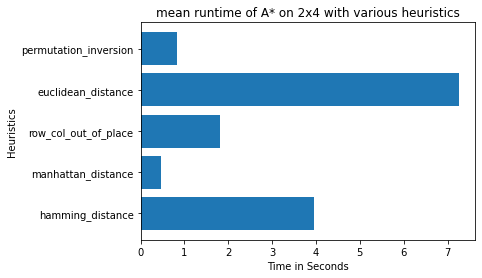

{'hamming_distance': 15.4, 'manhattan_distance': 15.36, 'row_col_out_of_place': 15.46, 'euclidean_distance': 16.92, 'permutation_inversion': 18.66}


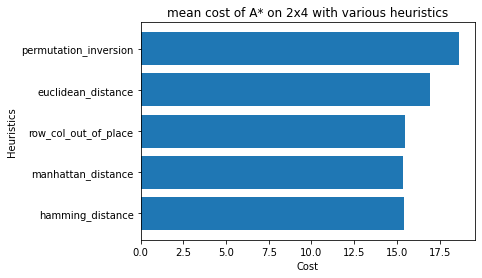

{'hamming_distance': 4075.82, 'manhattan_distance': 211.18, 'row_col_out_of_place': 920.64, 'euclidean_distance': 9500.56, 'permutation_inversion': 612.4}


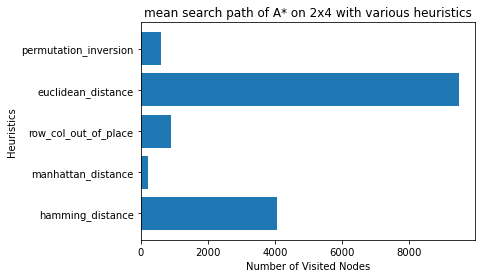

In [113]:
plot_stats(stats,(2,4),'A*')

{'hamming_distance': 0.11, 'manhattan_distance': 0.06, 'row_col_out_of_place': 0.12, 'euclidean_distance': 6.14, 'permutation_inversion': 0.81}


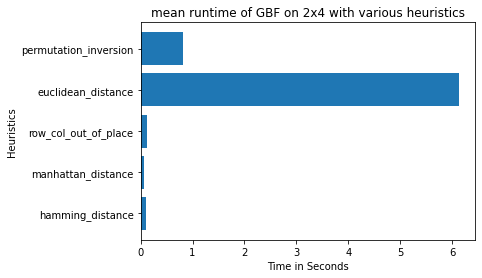

{'hamming_distance': 28.48, 'manhattan_distance': 23.66, 'row_col_out_of_place': 27.4, 'euclidean_distance': 62.26, 'permutation_inversion': 35.02}


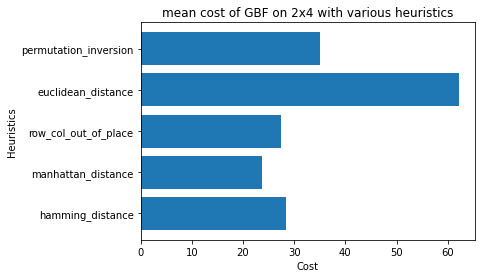

{'hamming_distance': 219.12, 'manhattan_distance': 43.16, 'row_col_out_of_place': 105.08, 'euclidean_distance': 13426.22, 'permutation_inversion': 1148.88}


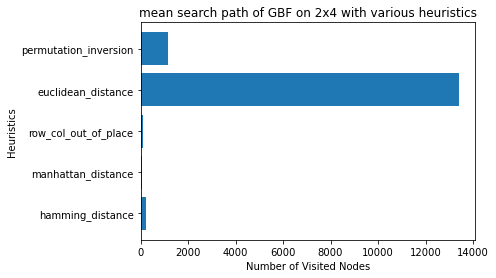

In [114]:
plot_stats(stats,(2,4),'GBF')

{'hamming_distance': 3.95, 'manhattan_distance': 0.46, 'row_col_out_of_place': 1.82, 'euclidean_distance': 7.27, 'permutation_inversion': 0.82}


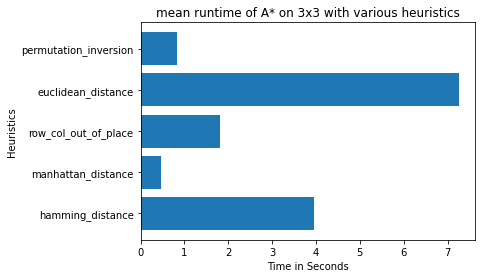

{'hamming_distance': 15.4, 'manhattan_distance': 15.36, 'row_col_out_of_place': 15.46, 'euclidean_distance': 16.92, 'permutation_inversion': 18.66}


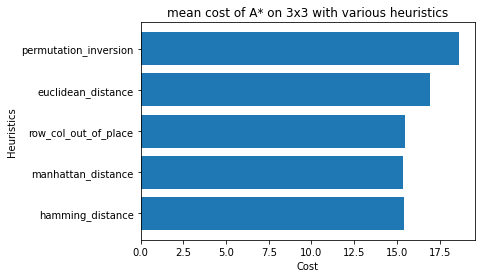

{'hamming_distance': 4075.82, 'manhattan_distance': 211.18, 'row_col_out_of_place': 920.64, 'euclidean_distance': 9500.56, 'permutation_inversion': 612.4}


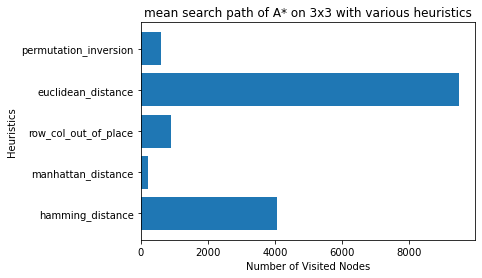

In [116]:
plot_stats(stats,(3,3),'A*')

{'hamming_distance': 0.11, 'manhattan_distance': 0.06, 'row_col_out_of_place': 0.12, 'euclidean_distance': 6.14, 'permutation_inversion': 0.81}


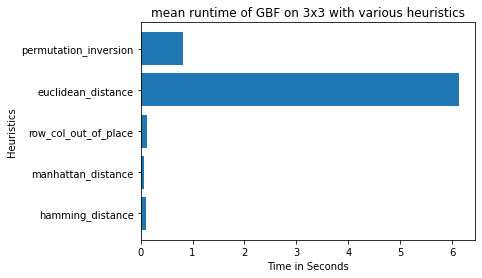

{'hamming_distance': 28.48, 'manhattan_distance': 23.66, 'row_col_out_of_place': 27.4, 'euclidean_distance': 62.26, 'permutation_inversion': 35.02}


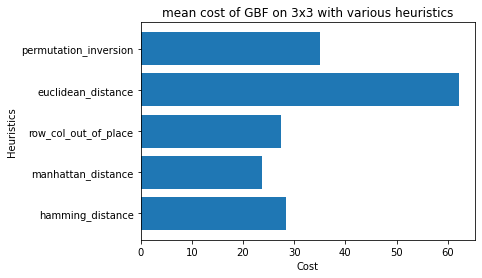

{'hamming_distance': 219.12, 'manhattan_distance': 43.16, 'row_col_out_of_place': 105.08, 'euclidean_distance': 13426.22, 'permutation_inversion': 1148.88}


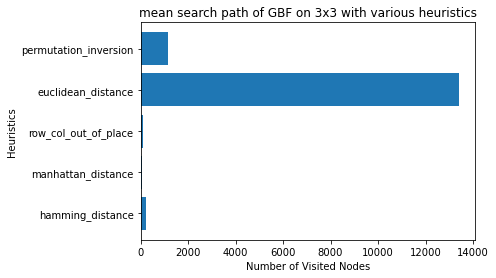

In [117]:
plot_stats(stats,(3,3),'GBF')

In [63]:
def establish_cost_baseline(puzzles: list):
    '''Run UCS on puzzles to establish the minimum cost solution'''
    results = []

    for puzzle in tqdm(puzzles):
        results.append(search.uniform_cost(board=Board(puzzle)))
    
    return results

In [66]:
start = time.time()
two_by_two_baseline = establish_cost_baseline(two_by_two)
elapsed = round(time.time()-start,2)
print(f'Ran UCS on the 50 2x4 in {elapsed} seconds')

100%|██████████| 50/50 [06:54<00:00,  8.29s/it]
Ran UCS on the 50 2x4 in 417.99 seconds


In [95]:
# start = time.time()
# three_by_three_baseline = establish_cost_baseline(three_by_three)
# elapsed = round(time.time()-start,2)
# print(f'Ran UCS on the 50 2x4 in {elapsed} seconds')